In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from MethodsUpdate import *

# create a copy of the list of Paulistrings
# Paulistrings is a list of Strings, which contain 'X', 'Z', 'Y' and '1'

# list of Paulistrings
# PauliStrings = ['X1ZY', 'X1XX', 'XYYZ', 'ZZZZ', '1111', 'XXXX', 'YYYY']

# example for all possible two qubit pauli strings (16):
PauliStrings = ['XX', 'YY', 'ZZ', '11', 'X1', 'XY', 'XZ', 'Y1', 'YX', 'YZ', 'Z1', 'ZX', 'ZY', '1X', '1Y', '1Z']
 
# example from paper 
# PauliStrings = ['ZZ11', '111Z', '11Z1', '1Z11', 'Z111', 'Z1Z1', '1ZZ1', 'Z11Z', '1Z1Z', '11ZZ', 'XXYY', 'YXXY', 'XYYX', 'YYXX']

# cofficients of Pauli strings in Hamiltonian
import random 
weightsList = [random.random() for i in range(len(PauliStrings))]

weights = {}

# create weights dictionary 
for i in range(len(weightsList)): 
    weights[PauliStrings[i]] = weightsList[i]



def FindAndDrawCliques(pauliStrings: list, draw: bool):

    # check = check_Paulistring(pauliStrings)

    # if not check:
    #     return None 


    Graph_QWC = create_Graph_QWC(pauliStrings)
    Graph_GC, edge_colors_GC = create_Graph_GC(pauliStrings)


    # to keep track of time, to compare runtimes for different algorithms to each other, first calculate number of families for GC
    start = time.time()
    result_GC = find_max_clique(Graph_GC, [])
    end = time.time()
    time_GC_ms = np.round(1000*(end-start), 3)


    # then, calculate number of families for QWC
    start = time.time()
    result_QWC = find_max_clique(Graph_QWC, [])
    end = time.time()
    time_QWC_ms = np.round(1000*(end-start), 3)


    if draw: 
        draw_Graph(Graph_GC, 'General Commutation', edge_colors_GC)
        draw_Graph(Graph_QWC, 'Cubit Wise Commutation', [])

        draw_new_Graph(result_GC, 'GC, #families: ' + str(len(result_GC)) + ', #naive: ' + str(len(pauliStrings)) + ', time: ' + str(time_GC_ms) + 'ms')
        draw_new_Graph(result_QWC, 'QWC, #families: ' + str(len(result_QWC)) + ', #naive: ' + str(len(pauliStrings)) + ', time: ' + str(time_QWC_ms) + 'ms')


    return result_GC, result_QWC


'''
Further ideas: 

comparing sets of Pauli strings of different lengths to each other, depending on the element the Hamiltonian stems from. 
The number of Pauli strings will increase with the complexity of the molecule. 

And the computation time will increase as well. 

The idea is, comparing the computation time of estimating the ground state energy for the three methods: Naive, QWC and GC.

Also, one could compare the times it takes to partition the Paulistrings into commuting families with the two different methods, GC and QWC. 
'''


'\nFurther ideas: \n\ncomparing sets of Pauli strings of different lengths to each other, depending on the element the Hamiltonian stems from. \nThe number of Pauli strings will increase with the complexity of the molecule. \n\nAnd the computation time will increase as well. \n\nThe idea is, comparing the computation time of estimating the ground state energy for the three methods: Naive, QWC and GC.\n\nAlso, one could compare the times it takes to partition the Paulistrings into commuting families with the two different methods, GC and QWC. \n'

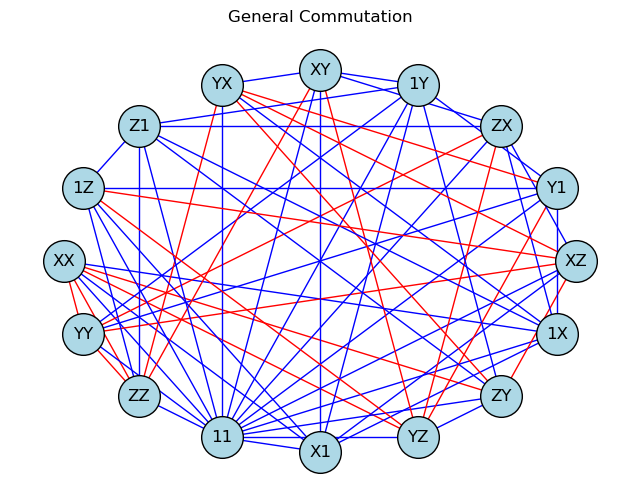

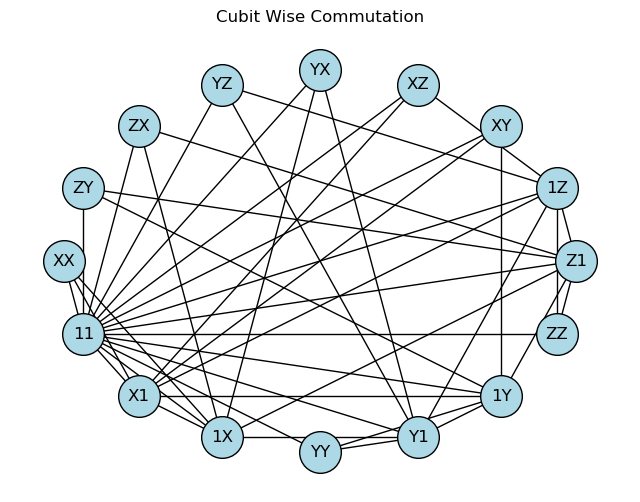

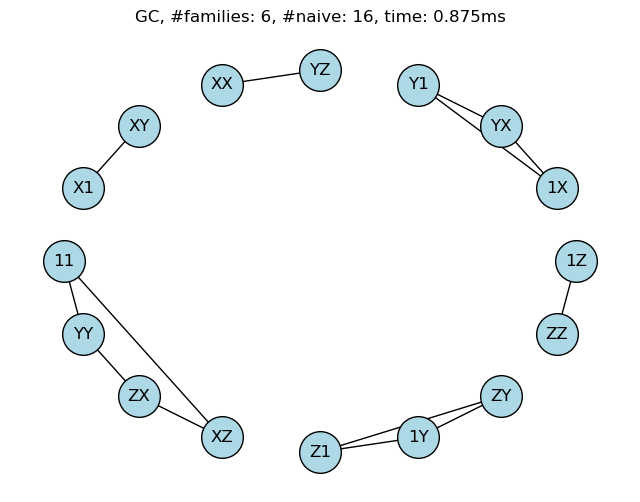

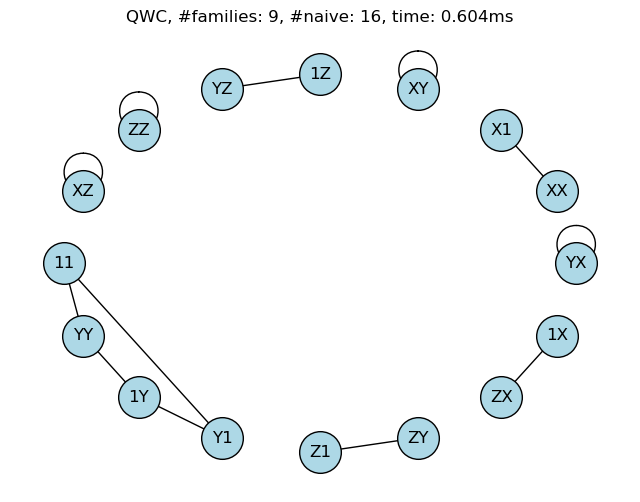

ZZ
(4, 4)
1Z
(4, 4)
YZ
(4, 4)
XX
(4, 4)
XY
(4, 4)
X1
(4, 4)


[['XY', 'X1'], ['ZZ', '1Z'], ['YZ', 'XX']]

In [4]:
'''
We have found and drawn the cliques. Now we want to impose some further restrictions 
'''

# remember
assert type(weights) == dict

def ReturnChosenClique(pauliStrings: list, weights: dict, QWC: bool = False, draw: bool = False):
    '''
    In this function, we search for the clique in a list of cliques as returned by 
    FindAndDrawCliques()
    that:
    1. has only linearly independent pauli strings 
    2. is not longer than the number of qubits (len(PauliString))
    3. if the clique is shorter, pad it with trivial Pauli strings 
    4. return a cliques list ordered by weight 

    Note that in this approach, we simply throw away cliques that are too big. 
    A different approach would be to cut the cliques that are too big in pieces and implement a seach algorithm to find out how to cut these cliques 
    '''
    cliqueListQWCGC = FindAndDrawCliques(pauliStrings=pauliStrings, draw= draw)


    if QWC: 
        cliqueList = cliqueListQWCGC[1]
    else: 
        cliqueList = cliqueListQWCGC[0]
    
    nQ = len(cliqueList[0][0])


    '''
    Remove cliques that are too big
    '''

    indicesToRemove = []

    for i in range(len(cliqueList)):
        clique = cliqueList[i]
        if len(clique) > nQ:
            indicesToRemove.append(i)
            continue

    cliqueList = [cliqueList[i] for i in range(len(cliqueList)) if i not in indicesToRemove]


    # list of cliques that are not too long 
    newCliqueList: list = []

    # summed weights for these cliques 
    newWeightList: list = []

    for clique in cliqueList: 
        
        if not checkLinearIndependency(clique):
            print('These matrices are not linearly independent ')
            continue

        newWeightList.append(SummedWeight(clique, weights))

        if len(clique) < nQ: 
            newClique = PadClique(clique)

            newCliqueList.append(newClique)

            continue


        newCliqueList.append(clique)

    # order by weight
    weightsArray = np.array(newWeightList)

    # decreasing in weight
    sortedIndices = np.argsort(weightsArray)[::-1]

    newCliqueList = [newCliqueList[i] for i in sortedIndices]



    return newCliqueList



PauliStrings = ['XX', 'YY', 'ZZ', '11', 'X1', 'XY', 'XZ', 'Y1', 'YX', 'YZ', 'Z1', 'ZX', 'ZY', '1X', '1Y', '1Z']

import random 
weightsList = [random.random() for i in range(len(PauliStrings))]
weightsList = [10, 0, 5, 0, 100, 0, 0, 0, 0, 0, 50, 0, 0, 100, 0, 50]
weights = {}
# create weights dictionary 
for i in range(len(weightsList)): 
    weights[PauliStrings[i]] = weightsList[i]
ReturnChosenClique(pauliStrings=PauliStrings, weights= weights, QWC= False, draw= True)

